# plot_transition.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 10 April 2023

Purpose: Plot timeseries normalized by large eddy turnover time and instantaneous cross-sections of w and Rww

In [44]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn

Settings

In [45]:
# location of netCDF simulation output
output = "/home/rfrost/simulations/nc/"
# name of simulation
sim = "full_step_15"
dnc = f"{output}{sim}/"

# ug of simulation in m/s
ug = sim[10:]
# heights being analyzed
heights = np.array([0.25])

# timesteps
t0 = 576000
t1 = 1152000
# start/end times in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# flag to normalize time by TL
norm_time = False

### Read in data

In [46]:
# volumetric stats
stats = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
# calculate large eddy turnover time
TL = stats.zi.isel(time=0) / stats.wstar.isel(time=0)
TL = TL / 3600
# convert time to hours
stats["time"] = stats.time / 3600 + t0hr
# center time around forcing change
stats["time"] = stats.time
ntime = stats.time.size

# # roll factor
# R = []
# h = heights * 100
# h = h.astype(int)
# for i in h:
#     r = xr.load_dataarray(f"{dnc}rollfactor_zzi{i}_raw.nc")
#     R.append(r)
# # convert time to hours
# for i, r in enumerate(R):
#     r["time"] = (r.time) / 3600 + t0hr

# autocorrelation
R2d = xr.open_dataset(f"{dnc}R_2d_rot.nc")
# convert time to hours and center around surface forcing change
R2d["time"] = R2d.time / 3600 + t0hr

# length scales
ls = xr.open_dataset(f"{dnc}{t0}_{t1}_length_scale_rot.nc")

# normalize time by TL if desired
if norm_time:
    # stats
    stats["time"] = stats.time / TL
    # roll factor
    for i, r in enumerate(R):
        r["time"] = r.time / TL
    # 2d autocorr
    R2d["time"] = R2d.time / TL

In [47]:
# array to hold indicies of z/zi
jz = np.zeros(ntime)
# loop over time
for jt in range(ntime):
    # find jz for defined z/zi
    jz[jt] = abs(stats.z/stats.zi[jt] - heights[0]).argmin()

jz = jz.astype(int)

### Timeseries plots

In [48]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
colors = seaborn.color_palette("rocket_r", len(heights))

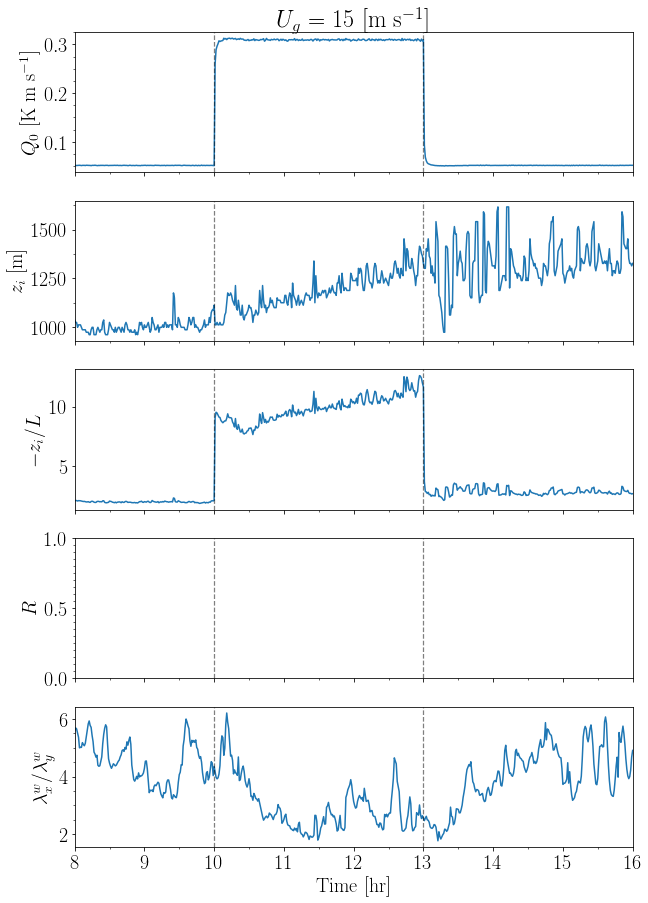

In [49]:
fig, ax = plt.subplots(figsize=(10,15), nrows=5, sharex=True)

# Q0
ax[0].plot(stats.time, stats.tw_cov_tot.isel(z=0))
# zi
ax[1].plot(stats.time, stats.zi)
# -zi/L
ax[2].plot(stats.time, stats.zi_L)
# for i, r in enumerate(R):
#     # R
#     ax[3].plot(r.time, r)#, c=colors[i], label=f"$z/z_i$ = {heights[i]}")
# length scale ratio
ax[4].plot(r.time, ls.rolls[:,jz[jt]]/ls.normal[:,jz[jt]])

# clean up
ax[0].set_ylabel("$Q_0$ [K m s$^{-1}$]")
ax[1].set_ylabel("$z_i$ [m]")
ax[2].set_ylabel("$-z_i / L$")
ax[3].set_ylabel("$R$")
# ax[3].legend(frameon=False)
ax[3].set_xlim(8,16)
ax[4].set_ylabel("$\lambda_{x}^{w} / \lambda_{y}^{w}$")
ax[4].set_xlabel("Time [hr]")

# add vertical line at t0
for iax in ax:
    iax.axvline(x=10, ls="--", c="black", alpha=0.5, lw=1.25)
    iax.axvline(x=13, ls="--", c="black", alpha=0.5, lw=1.25)
    # minor ticks on x axis
    iax.xaxis.set_minor_locator(MultipleLocator(0.5))

# add minor ticks to y axis
ax[0].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[1].yaxis.set_minor_locator(MultipleLocator(125))
ax[2].yaxis.set_minor_locator(MultipleLocator(5))
ax[3].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[4].yaxis.set_minor_locator(MultipleLocator(0.5))

fig.tight_layout
ax[0].set_title(f"$U_g$ = {ug} [m s$^{{-1}}$]")
plt.show()
plt.close()

IndexError: list index out of range

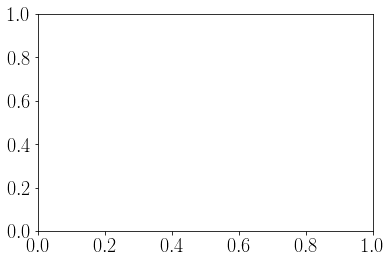

In [50]:
fig, ax = plt.subplots()

ax.plot(stats.zi_L.rolling(time=12).mean(), R[0].rolling(time=12).mean())

ax.set_ylabel("$R$")
ax.set_xlabel("$-z_i/L$")

Roll factor

No handles with labels found to put in legend.


Text(0.5, 0, '$(t - t_0) / T_L$')

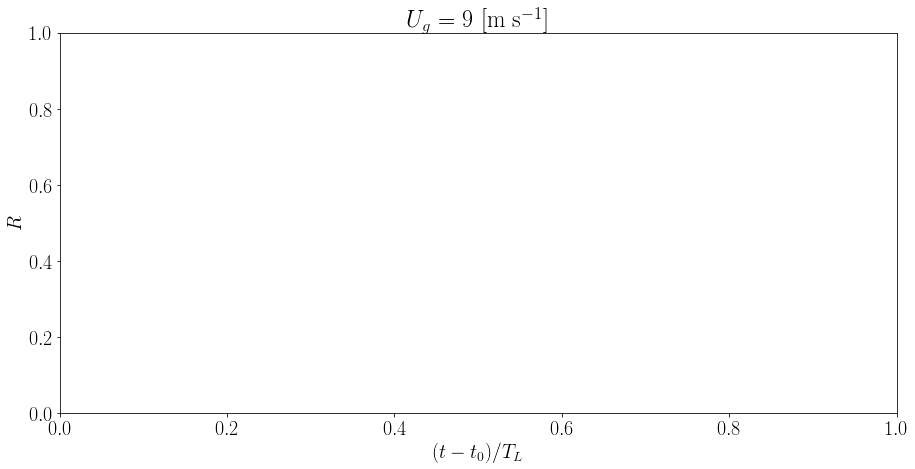

In [51]:
fig, ax = plt.subplots(figsize=(15,7))

for i, r in enumerate(R):
    # R
    ax.plot(r.time, r, c=colors[i], label=f"$z/z_i$ = {heights[i]}")

# ax.set_xlim(-2,5)
ax.legend(frameon=False)
ax.set_title("$U_g$ = 9 [m s$^{-1}$]")
ax.set_ylabel("$R$")
ax.set_xlabel("$(t - t_0) / T_L$")

<bound method Figure.tight_layout of <Figure size 2160x1080 with 3 Axes>>

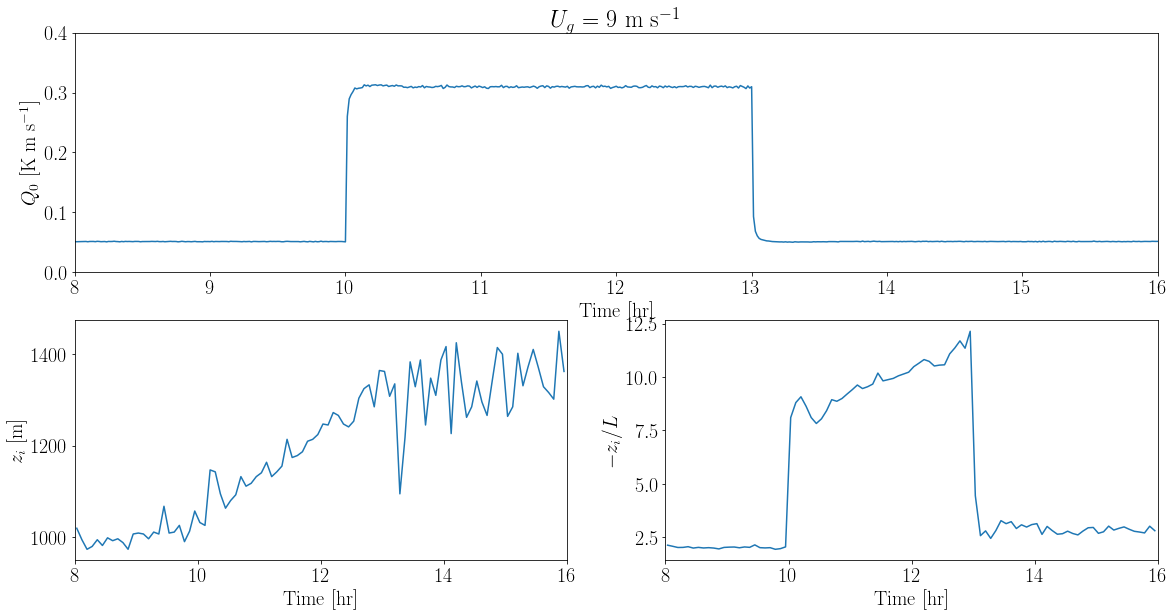

In [52]:
fig, ax = plt.subplots(nrows=2, figsize=(30,15), sharex=True)

# for i, s in enumerate(df_all):
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
ax1.plot(stats.time, stats.tw_cov_tot.isel(z=0))
ax2 = plt.subplot2grid((3,3), (1,0), colspan=1)
ax2.plot(stats.time.coarsen(time=6, boundary="trim").mean(), stats.zi.coarsen(time=6, boundary="trim").mean())
ax3 = plt.subplot2grid((3,3), (1,1), colspan=1)
ax3.plot(stats.time.coarsen(time=6, boundary="trim").mean(), stats.zi_L.coarsen(time=6, boundary="trim").mean())

ax1.set_xlim(8,16), ax2.set_xlim(8,16), ax3.set_xlim(8,16)
ax1.set_ylim(0,0.4)
ax1.xaxis.set_major_locator(MultipleLocator(1)), ax2.xaxis.set_major_locator(MultipleLocator(2)), ax3.xaxis.set_major_locator(MultipleLocator(2))
ax1.set_ylabel("$Q_0$ [K m s$^{-1}$]"), ax2.set_ylabel("$z_i$ [m]"), ax3.set_ylabel("$-z_i / L$")
ax1.set_xlabel("Time [hr]"), ax2.set_xlabel("Time [hr]"), ax3.set_xlabel("Time [hr]")
ax1.set_title("$U_g$ = 9 m s$^{-1}$")

fig.tight_layout